In [1]:
!pip install osmnx spopt esda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 27.1 MB/s eta 0:00:00


In [2]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
import libpysal as ps
import esda
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from spopt.region import Skater
import osmnx as ox

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-richardaguilera09')

#Descarga automatica de capas vectoriales

In [4]:
region  = "Región Metropolitana de Santiago, Chile"

## Comunas
Fuente: https://www.ide.cl/index.php/noticias/actualizacion-de-la-cartografia-de-division-politica-administrativa-en-chile

In [5]:
communes = gpd.read_file("datos/comunas/COMUNAS_v1.shp")
print(communes.columns)
communes.crs

Index(['CUT_REG', 'CUT_PROV', 'CUT_COM', 'REGION', 'PROVINCIA', 'COMUNA',
       'SUPERFICIE', 'geometry'],
      dtype='object')


<Geographic 2D CRS: GEOGCS["GCS_SIRGAS-Chile",DATUM["SIRGAS-Chile",SPH ...>
Name: GCS_SIRGAS-Chile
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: SIRGAS-Chile
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
santiago_communes = communes[communes["REGION"] == "Metropolitana de Santiago"]
santiago_communes.head()

,CUT_REG,CUT_PROV,CUT_COM,REGION,PROVINCIA,COMUNA,SUPERFICIE,geometry
15,13,131,13130,Metropolitana de Santiago,Santiago,San Miguel,9.63,"POLYGON ((-70.65492 -33.47644, -70.65377 -33.4..."
18,13,131,13118,Metropolitana de Santiago,Santiago,Macul,12.81,"POLYGON ((-70.59021 -33.51035, -70.59069 -33.5..."
24,13,131,13119,Metropolitana de Santiago,Santiago,Maipú,136.81,"POLYGON ((-70.72199 -33.47321, -70.72214 -33.4..."
28,13,131,13123,Metropolitana de Santiago,Santiago,Providencia,14.45,"POLYGON ((-70.63156 -33.44983, -70.63163 -33.4..."
30,13,131,13131,Metropolitana de Santiago,Santiago,San Ramón,6.32,"POLYGON ((-70.65495 -33.55497, -70.65449 -33.5..."


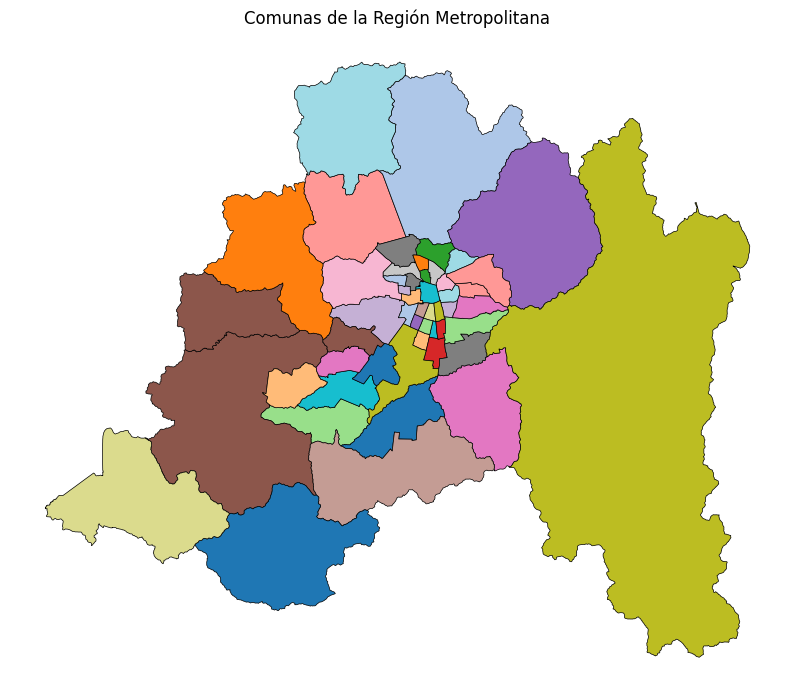

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
#santiago_communes.boundary.plot(ax=ax, color='black', linewidth=0.5)
santiago_communes.plot(
    column='COMUNA',
    ax=ax,
    cmap='tab20',
    edgecolor='black',
    linewidth=0.5,
    legend=False,
    legend_kwds={
        'loc': 'upper center',
        'bbox_to_anchor': (0.5, 1.02),  # Entre título y mapa
        'ncol': 3,
        'fontsize': 8,
        'title': 'Comunas'
    }
)
ax.set_title("Comunas de la Región Metropolitana")
plt.axis('off')
plt.show()

## Red Vial

In [9]:
roads = ox.features_from_place(region, tags={'highway': True})
roads = roads[roads.geometry.notnull()].to_crs(epsg=4326)
roads.to_file("datos/redvial/roads.geojson", driver="GeoJSON")

In [10]:
roads.head()

geometry bench          highway name  \
element id                                                                
node    386138   POINT (-70.64625 -33.4429)   NaN  traffic_signals  NaN   
        386140  POINT (-70.64767 -33.44304)   NaN  traffic_signals  NaN   
        386147  POINT (-70.65038 -33.44367)   NaN         crossing  NaN   
        386157   POINT (-70.6584 -33.43695)   NaN  traffic_signals  NaN   
        386184  POINT (-70.64248 -33.43346)   NaN  traffic_signals  NaN   

               shelter public_transport  bus description direction  ref  ...  \
element id                                                               ...   
node    386138     NaN              NaN  NaN         NaN       NaN  NaN  ...   
        386140     NaN              NaN  NaN         NaN       NaN  NaN  ...   
        386147     NaN              NaN  NaN         NaN       NaN  NaN  ...   
        386157     NaN              NaN  NaN         NaN       NaN  NaN  ...   
        386184     NaN              NaN  NaN         NaN       NaN  NaN  ...   

               source:image restriction:bus substance locked airside  \
element id                                                             
node    386138          NaN             NaN       NaN    NaN     NaN   
        386140          NaN             NaN       NaN    NaN     NaN   
        386147          NaN             NaN       NaN    NaN     NaN   
        386157          NaN             NaN       NaN    NaN     NaN   
        386184          NaN             NaN       NaN    NaN     NaN   

               foot:backward oneway:foot  acp aeroway  dur  
element id                                                  
node    386138           NaN         NaN  NaN     NaN  NaN  
        386140           NaN         NaN  NaN     NaN  NaN  
        386147           NaN         NaN  NaN     NaN  NaN  
        386157           NaN         NaN  NaN     NaN  NaN  
        386184           NaN         NaN  NaN     NaN  NaN  

[5 rows x 428 columns]

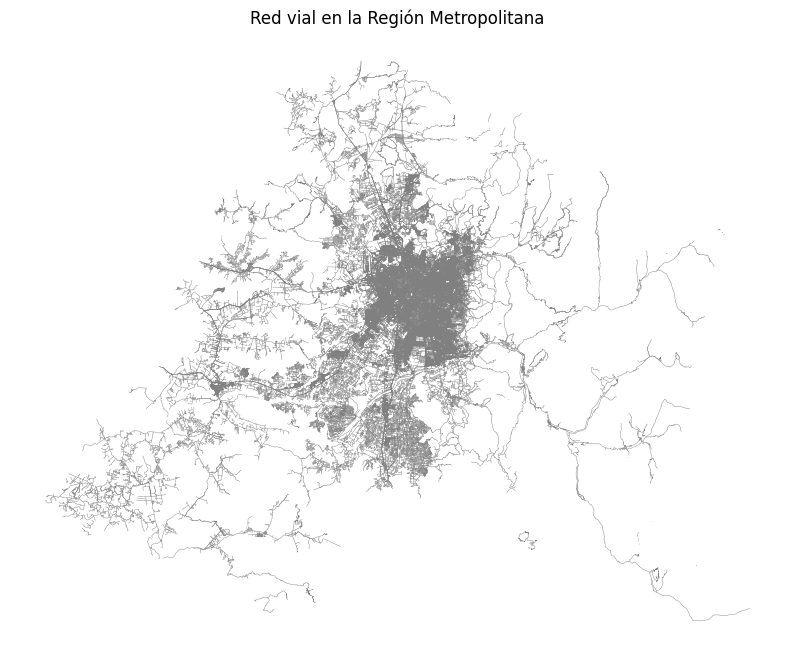

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
roads = roads[roads.geometry.type == 'LineString']
roads.plot(ax=ax, color='gray', linewidth=0.3)
ax.set_title("Red vial en la Región Metropolitana")
plt.axis('off')
plt.show()

## Ciclo vías
Fuente: https://www.arcgis.com/apps/dashboards/d2c380a49743480e86a628daeb696e9f

In [12]:
bike_paths = gpd.read_file("datos/ciclovias/CICLOVnac_2s2024_1.shp").to_crs(epsg=4326)
print(communes.columns)
bike_paths.crs

Index(['CUT_REG', 'CUT_PROV', 'CUT_COM', 'REGION', 'PROVINCIA', 'COMUNA',
       'SUPERFICIE', 'geometry'],
      dtype='object')


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
santiago_bike_paths = bike_paths[bike_paths["REGION"] == "13-Metropolitana"]
santiago_bike_paths.head()

,IDENTIFICA,REGION,COMUNA,EJE_VIA,INICIO,FIN,KM,TIPO,CARAC_FUNC,EMPLAZA_TE,...,CARTERA,BIP_o_PMU,NOMBRE_PRO,NORMATIVA,RESOLUCION,CUT_REG,CUT_COM,YEAR_EJECU,Shape_Leng,geometry
0,131300003,13-Metropolitana,San Miguel,Gran Avenida,Lo Ovalle,Isabel Riquelme,4.20,ciclovía,s_i,s_i,...,GORE,30392928,Construcción Ciclovías Comuna Lo Barnechea,s_i,s_i,13.0,13130.0,0.0,0.038386,"LINESTRING Z (-70.64823 -33.47764 0, -70.64824..."
1,134010043,13-Metropolitana,San Bernardo,Ochagavía-América,Las Acacias,Eucaliptus,5.12,ciclovía,s_i,s_i,...,Municipios,30163923,"CONSTRUCCION CICLOVÍA AMÉRICA - OCHAGAVÍA,",s_i,s_i,13.0,13401.0,0.0,0.047376,"LINESTRING Z (-70.69663 -33.56115 0, -70.69689..."
2,131110018,13-Metropolitana,La Granja,Yungay,Raúl Silva Henríquez,Coronel,0.80,ciclovía,s_i,s_i,...,Municipios,s_i,PIIMEP,s_i,s_i,13.0,13111.0,0.0,0.008146,"LINESTRING Z (-70.62542 -33.52428 0, -70.61731..."
41,131190016,13-Metropolitana,Maipú,Camino a Lonquén,Av. Lo Espejo,Limite Comunal,6.52,smp,bidireccional,berma,...,MOP,s_i,s_i,s_i,s_i,13.0,13119.0,0.0,0.063008,"LINESTRING Z (-70.72624 -33.52402 0, -70.73258..."
42,133010003,13-Metropolitana,Colina,Av Camino La Catana,Av. Ignacio Carrera Pinto,S_I,0.58,ciclovía,bidireccional,acera,...,Privados,s_i,s_i,Anteproyecto aprobado,4500/2024,13.0,13301.0,0.0,0.006704,"LINESTRING Z (-70.65672 -33.20776 0, -70.6546 ..."


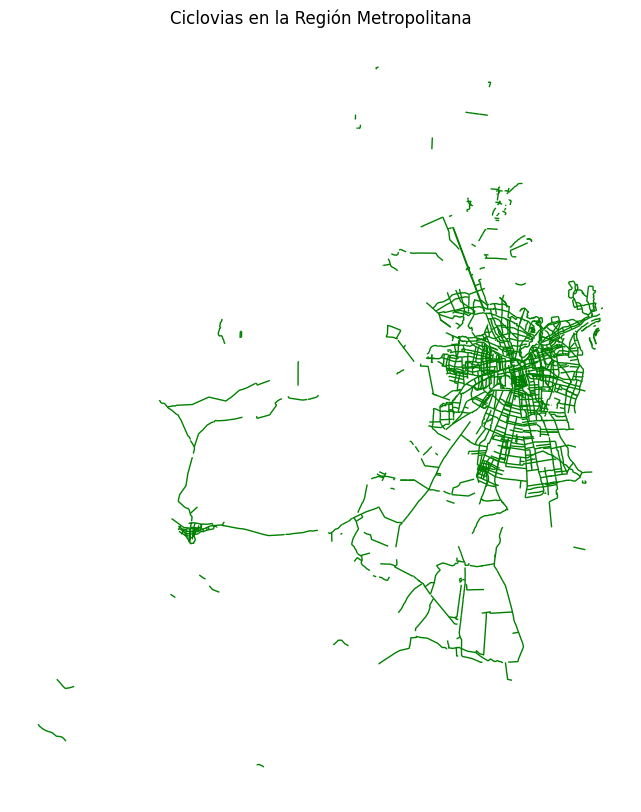

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_bike_paths.plot(ax=ax, color='green', linewidth=1)
ax.set_title("Ciclovias en la Región Metropolitana")
plt.axis('off')
plt.show()

## Área de estudio: Región metropolinata

In [15]:
# Unir todas las geometrías en una sola
roi_union = santiago_communes.unary_union

# Crear un GeoDataFrame con la geometría unificada
roi_gdf = gpd.GeoDataFrame(geometry=[roi_union], crs="EPSG:4326")

# Convertir a ee.Geometry
roi = geemap.geopandas_to_ee(roi_gdf).geometry()

<ipython-input-15-3919654371>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  roi_union = santiago_communes.unary_union


Función para agregar índices espectrales a imágenes Landsat

In [16]:
def add_indices(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    lst = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15).rename('LST')  # °C
    # albedo = image.expression(
    #      '0.356*B2 + 0.130*B4 + 0.373*B5 + 0.085*B6 + 0.072*B7 - 0.0018', {
    #          'B2': image.select('SR_B2'),
    #          'B4': image.select('SR_B4'),
    #          'B5': image.select('SR_B5'),
    #          'B6': image.select('SR_B6'),
    #          'B7': image.select('SR_B7')
    #      }).multiply(0.0000275).add(-0.2).rename('Albedo')
    return image.addBands([ndvi, ndbi, lst])

Colección de Landsat 8

In [17]:

def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    # Bits 3 y 4 son nubes y sombras de nubes
    cloud_bit = 1 << 3
    shadow_bit = 1 << 4
    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(qa.bitwiseAnd(shadow_bit).eq(0))
    return image.updateMask(mask)

def process_epoch(start_date, end_date):
    return (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterDate(start_date, end_date)
            .filterBounds(roi)
            .map(mask_clouds)
            .filter(ee.Filter.lt('CLOUD_COVER', 20))
            #.map(lambda img: img.multiply(0.0000275).add(-0.2).copyProperties(img, ["system:time_start"]))
            .map(add_indices)
            .median()
            .clip(roi))

Composición temporal (mediana)

In [18]:
composite_2023 = process_epoch('2023-01-01', '2023-03-31')
composite_2024 = process_epoch('2024-01-01', '2024-03-31')

Visualización inicial con geemap

In [19]:
communes_ee = geemap.geopandas_to_ee(santiago_communes)

In [20]:
#albedo_stats = composite_2024.select('Albedo').reduceRegion(
#    reducer=ee.Reducer.minMax(),
#    geometry=roi,
#    scale=30,
#    maxPixels=1e9
#).getInfo()

#print(albedo_stats)

Verano 2023

In [22]:
lst_stats = composite_2023.select('LST').reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=30,
    maxPixels=1e9
).getInfo()
print(lst_stats)

{'LST_max': 59.21480993000003, 'LST_min': -13.96670727999998}


In [23]:
Map1 = geemap.Map(center=[-33.45, -70.65], zoom=10)

Map1.addLayer(communes_ee, {}, "Comunas")
Map1.addLayer(composite_2023.select('NDVI'), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI')
Map1.addLayer(composite_2023.select('NDBI'), {'min': -0.5, 'max': 0.5, 'palette': ['blue', 'white', 'brown']}, 'NDBI')
Map1.addLayer(composite_2023.select('LST'), {
    'min': lst_stats['LST_min'],
    'max': lst_stats['LST_max'],
    'palette': ['blue', 'yellow', 'red']}, 'LST')
#Map1.addLayer(composite_2023.select('Albedo'), {'min': -0.10364293699999999, 'max': 0.8793260555000001, 'palette': ['white','black']}, 'Albedo')

Map1

Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Verano 2024

In [24]:
# --- Obtener estadísticos reales del LST ---
lst_stats = composite_2024.select('LST').reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=30,
    maxPixels=1e9
).getInfo()


In [25]:
# --- Visualización inicial con geemap ---
Map2 = geemap.Map(center=[-33.45, -70.65], zoom=10)

Map2.addLayer(communes_ee, {}, "Comunas")
Map2.addLayer(composite_2024.select('NDVI'), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI')
Map2.addLayer(composite_2024.select('NDBI'), {'min': -0.5, 'max': 0.5, 'palette': ['blue', 'white', 'brown']}, 'NDBI')
Map2.addLayer(composite_2024.select('LST'), {
    'min': lst_stats['LST_min'],
    'max': lst_stats['LST_max'],
    'palette': ['blue', 'yellow', 'red']}, 'LST')

Map2


Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [26]:
def zonal_stats(image, band, year):
    return image.select(band).reduceRegions(
        collection=communes_ee,
        reducer=ee.Reducer.mean(),
        scale=30
    ).map(lambda f: f.set({'band': band, 'year': year}))

In [27]:
# Obtener estadísticas para cada índice y año
zst_ndvi_2023 = zonal_stats(composite_2023, 'NDVI', 2023)
zst_ndvi_2024 = zonal_stats(composite_2024, 'NDVI', 2024)
zst_ndbi_2023 = zonal_stats(composite_2023, 'NDBI', 2023)
zst_ndbi_2024 = zonal_stats(composite_2024, 'NDBI', 2024)
zst_lst_2023 = zonal_stats(composite_2023, 'LST', 2023)
zst_lst_2024 = zonal_stats(composite_2024, 'LST', 2024)

In [28]:
# Combinar resultados en una sola colección
zonal_all = zst_ndvi_2023.merge(zst_ndvi_2024)\
                         .merge(zst_ndbi_2023)\
                         .merge(zst_ndbi_2024)\
                         .merge(zst_lst_2023)\
                         .merge(zst_lst_2024)



In [29]:
task = ee.batch.Export.table.toDrive(
    collection=zonal_all,
    description='zonal_stats_comunas',
    fileFormat='CSV'
)
task.start()

Visualización de capas vectoriales

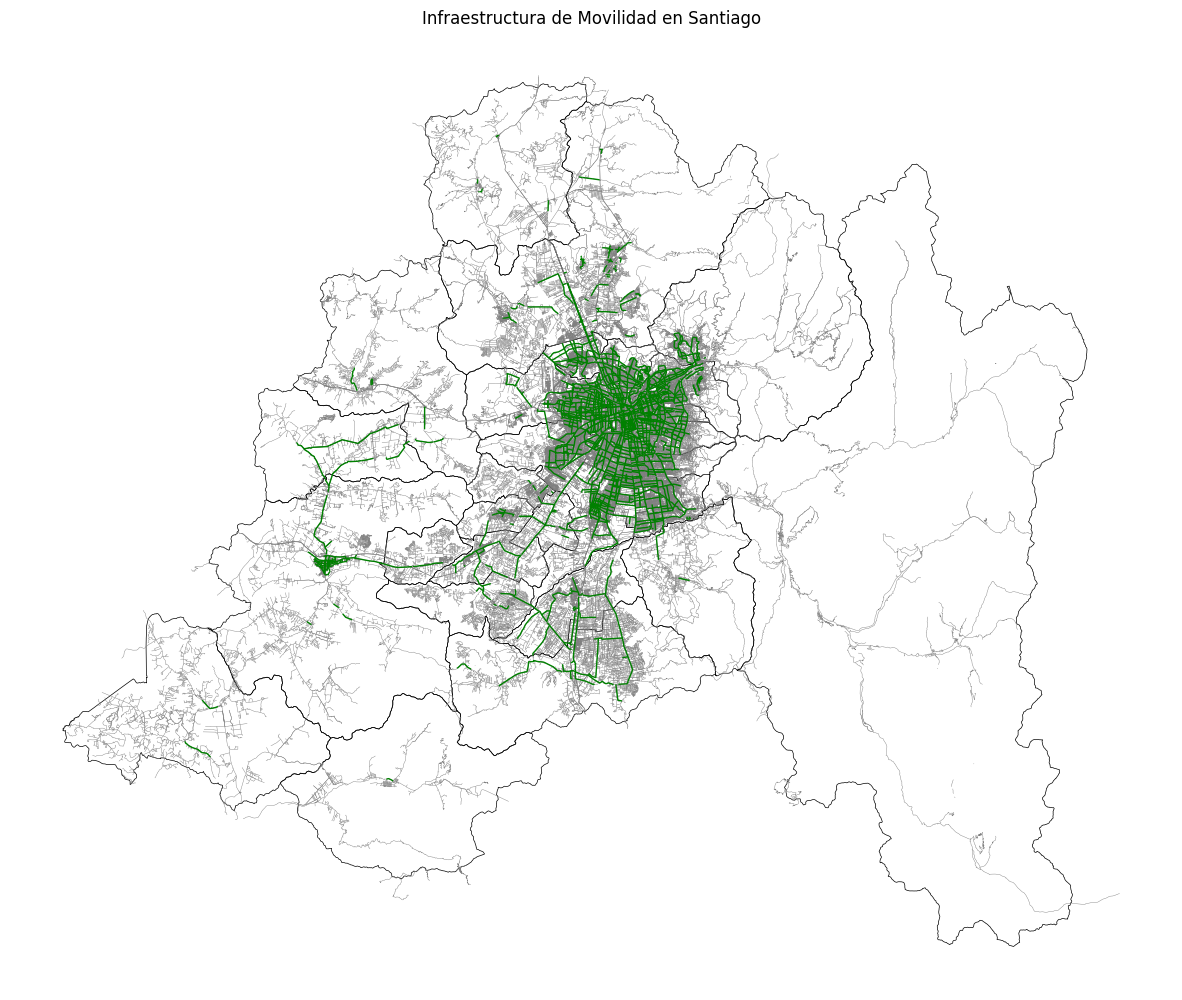

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))
roads = roads[roads.geometry.type == 'LineString']
santiago_communes.boundary.plot(ax=ax, color='black', linewidth=0.5)
roads.plot(ax=ax, color='gray', linewidth=0.3)
santiago_bike_paths.plot(ax=ax, color='green', linewidth=1)
ax.set_title("Infraestructura de Movilidad en Santiago")
plt.axis('off')
plt.show()

# Paraderos de bus y estaciones de metro

https://www.dtpm.cl/index.php/documentos/matrices-de-viaje (pagina principal de datos transporte publico, con info relevante)
https://www.dtpm.cl/descargas/tablas/Diccionario_campos_tabla_viajes_y_etapas(transparencia).xlsx (link de descarga excel)
https://www.dtpm.cl/descargas/tablas/Zona777_ADATRAP.rar (link de descarga shapefile)


Zones CRS: None
Zones bounds: [-70.882989 -33.675347 -70.457018 -33.316449]
Stops geometry ejemplo:
0    POINT (335889 6292782)
1    POINT (334219 6292589)
2    POINT (334281 6292830)
3    POINT (334732 6292745)
4    POINT (334731 6292721)
Name: geometry, dtype: geometry
Stops bounds post-reproyección: [-70.8739995  -33.66921077 -70.49352127 -33.31934588]


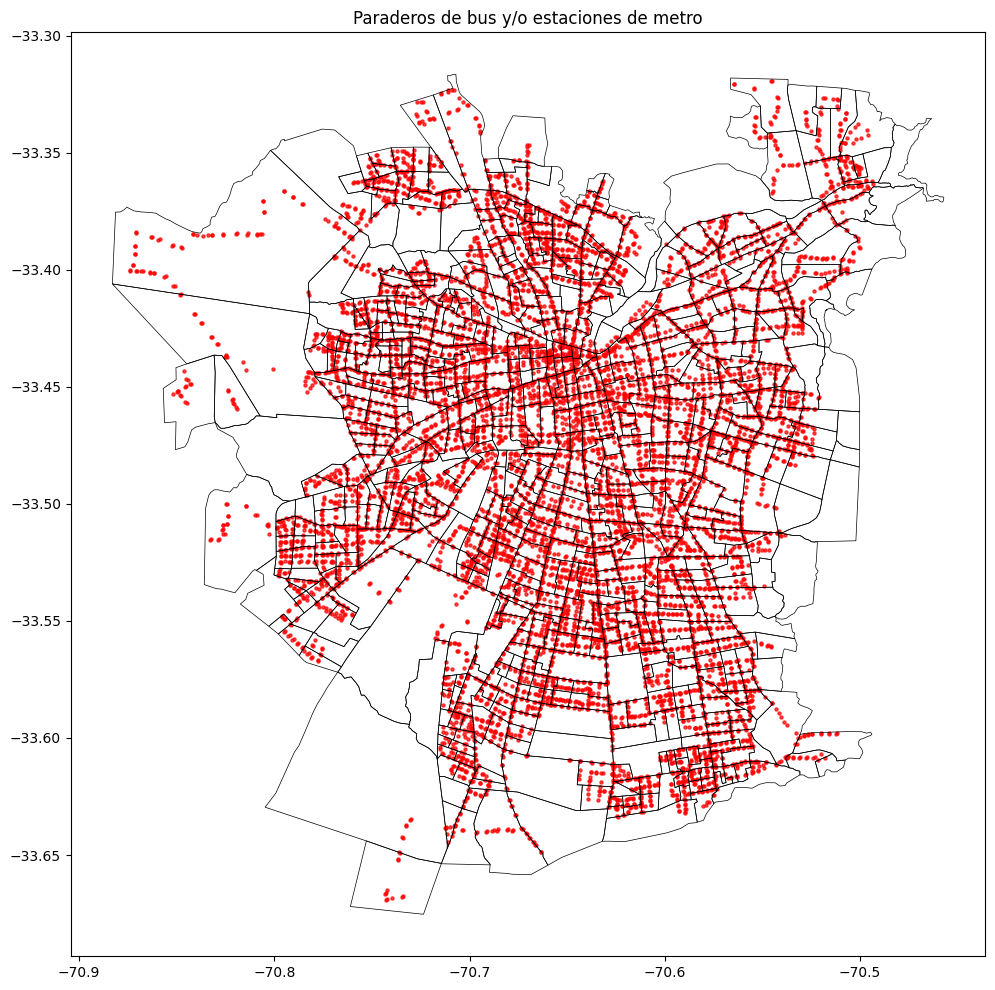

In [33]:
zones_gdf = gpd.read_file("datos/paraderos/Zonas777_V07_04_2014.shp")
print("Zones CRS:", zones_gdf.crs)
print("Zones bounds:", zones_gdf.total_bounds)

stops_df = pd.read_excel("datos/paraderos/DIC_777.xlsx")
stops_gdf = gpd.GeoDataFrame(
    stops_df,
    geometry=gpd.points_from_xy(stops_df['x'], stops_df['y'])
)

# Revisamos la geometria para "adivinar" que crs deberia tener
print("Stops geometry ejemplo:")
print(stops_gdf.geometry.head())
stops_gdf.set_crs(epsg=32719, inplace=True)

# Zonas no tenia un crs
if zones_gdf.crs is None:
    zones_gdf.set_crs(epsg=4326, inplace=True)

# reproyectamos
stops_gdf = stops_gdf.to_crs(zones_gdf.crs)

print("Stops bounds post-reproyección:", stops_gdf.total_bounds)

fig, ax = plt.subplots(figsize=(12, 12))
zones_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
stops_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.7)
plt.title("Paraderos de bus y/o estaciones de metro")
plt.show()


In [34]:
# Verificamos el crs de todo para combinar
print("CRS of layers:")
print(f"Roads: {roads.crs}")
print(f"Bike paths: {santiago_bike_paths.crs}")
print(f"Communes: {santiago_communes.crs}")
print(f"Stops with zones: {stops_gdf.crs}")

CRS of layers:
Roads: epsg:4326
Bike paths: EPSG:4326
Communes: GEOGCS["GCS_SIRGAS-Chile",DATUM["SIRGAS-Chile",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1254"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Stops with zones: EPSG:4326


In [35]:
target_crs = "EPSG:4326"
roads = roads.to_crs(target_crs)
santiago_bike_paths = santiago_bike_paths.to_crs(target_crs)
santiago_communes = santiago_communes.to_crs(target_crs)
stops_gdf = stops_gdf.to_crs(target_crs)

# nuevamente, por si acaso
print("CRS of layers:")
print(f"Roads: {roads.crs}")
print(f"Bike paths: {santiago_bike_paths.crs}")
print(f"Communes: {santiago_communes.crs}")
print(f"Stops with zones: {stops_gdf.crs}")

CRS of layers:
Roads: epsg:4326
Bike paths: EPSG:4326
Communes: EPSG:4326
Stops with zones: EPSG:4326


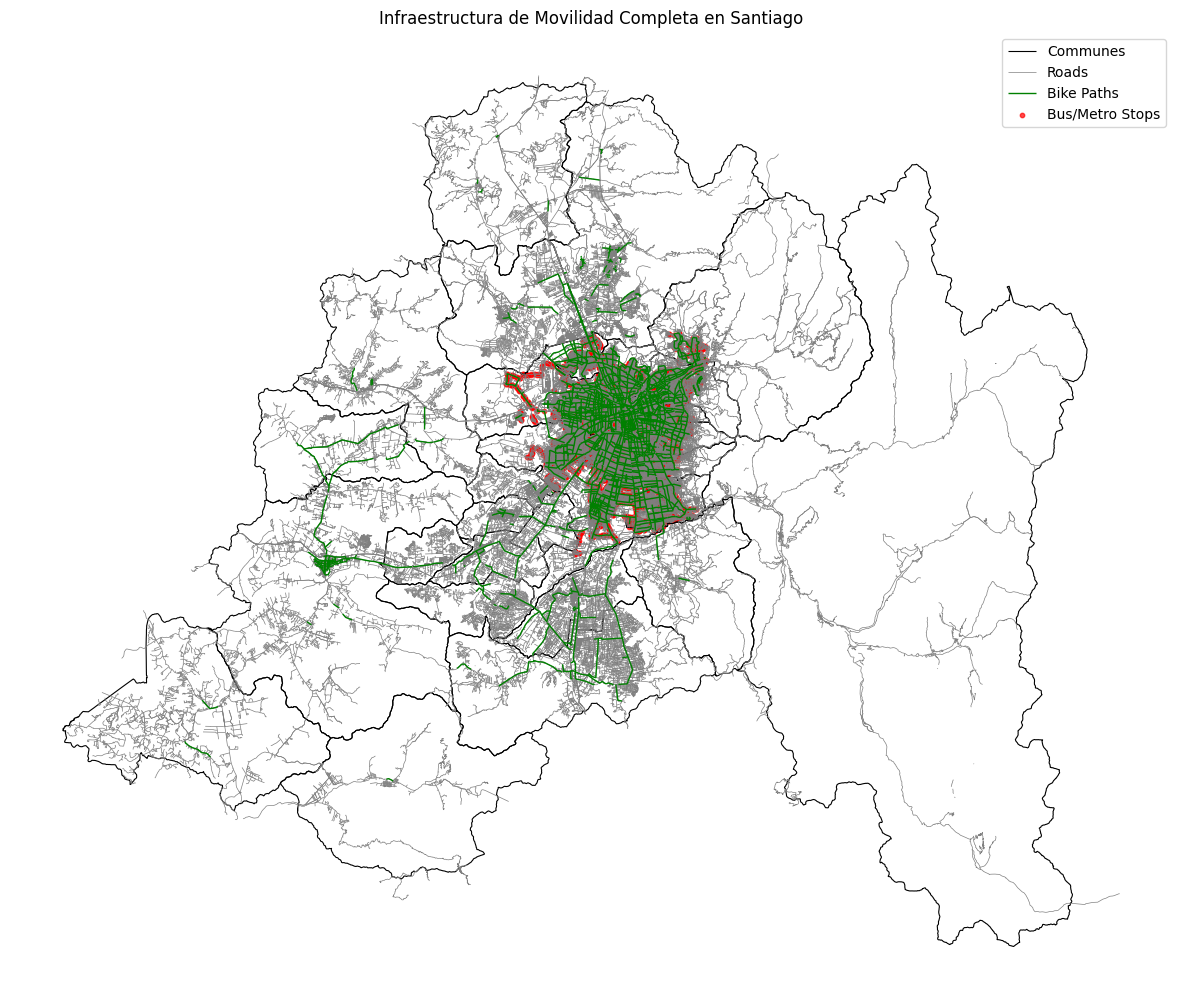

In [36]:
# capas vectoriales todas juntas
fig, ax = plt.subplots(figsize=(15, 15))

santiago_communes.boundary.plot(ax=ax, color='black', linewidth=0.8, label='Communes')
roads.plot(ax=ax, color='gray', linewidth=0.5, label='Roads')
santiago_bike_paths.plot(ax=ax, color='green', linewidth=1, label='Bike Paths')
stops_gdf.plot(ax=ax, color='red', markersize=10, alpha=0.7, label='Bus/Metro Stops')

ax.set_title("Infraestructura de Movilidad Completa en Santiago")
plt.legend()
plt.axis('off')
plt.show()
